In [1]:
from src import read_yfinance_crypto_data
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import yfinance as yf
import ewtpy
yf.__cache__ = {}

/root/cryptobot-enviroment/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2025-01-03 16:01:44.233772: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 16:01:44.251249: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 16:01:44.293174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735930904.361715   23907 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plu

In [2]:
seq_len = 90
tested_model = "xrp-ewt-p90-1f-2L.keras"

In [3]:
%reload_ext autoreload
%autoreload 2

#simulate training scaler
ticker = yf.Ticker("XRP-USD",)
puppet = ticker.history("max", "1d")

puppet = puppet["Close"].values.reshape(-1,1)
trainingScaler = MinMaxScaler()
normalizedTrainingData = trainingScaler.fit_transform(puppet)
normalizedTrainingData.shape

(2613, 1)

In [28]:
# connect to yfinance and get last 180 days data (data preparation eats first 90 days)
df = read_yfinance_crypto_data("XRP-USD", "6mo", "1d")
pastData = df["Close"].values.reshape(-1,1)

# normalize the pastData on the training scaler
normalizedPastData = trainingScaler.transform(pastData)
normalizedPastData.shape

(185, 1)

In [29]:
# load model
model = tf.keras.models.load_model(f"./saved_models/{tested_model}")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 90, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,155 (387.33 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,104 (258.22 KB)

In [30]:
initial_sum = 100
buyed = False
predictions = []
sum_by_epoch = []
for i in range(seq_len, len(normalizedPastData)):
    print(i)
    inputs = normalizedPastData[i-seq_len:i]
    print(inputs.shape)
    ewt, _, _ = ewtpy.EWT1D(inputs.flatten(), N=13)
    print(ewt.shape)
    pred = model(ewt.reshape(1, seq_len, 13))
    predictions.append(pred[0])
    predicted_price_difference = pred[0] - pastData[i-1]

    print(f"predicted dif {predicted_price_difference} sum: {initial_sum} {predicted_price_difference[0] > 0}")
   
    if (buyed):
        print(f"- predicted op diff: {pastData[i-1] - buy_value}")

    if (predicted_price_difference[0] > 0):
        if (not buyed):
            buy_value = pastData[i-1]
            buy_amount = initial_sum / pastData[i-1]
            buyed = True
            print(f"buy val: { buy_value} buy amount: {buy_amount}"  )
    else:
        if (buyed):
            operation_difference =  pastData[i-1] - buy_value
            print("op. diff ", operation_difference )
            initial_sum += operation_difference[0] * buy_amount[0]
            buyed = False
            print("sum ", initial_sum )
            print("\n\n")
    sum_by_epoch.append((initial_sum - 100)/10)

initial_sum


90
(90, 1)
(90, 13)
predicted dif [0.0171231] sum: 100 True
buy val: [0.61149198] buy amount: [163.53444292]
91
(90, 1)
(90, 13)
predicted dif [0.01461041] sum: 100 True
- predicted op diff: [-0.01396197]
92
(90, 1)
(90, 13)
predicted dif [0.0279792] sum: 100 True
- predicted op diff: [-0.071661]
93
(90, 1)
(90, 13)
predicted dif [0.00789726] sum: 100 True
- predicted op diff: [-0.08953899]
94
(90, 1)
(90, 13)
predicted dif [-0.00286663] sum: 100 False
- predicted op diff: [-0.077151]
op. diff  [-0.077151]
sum  87.38315411253564



95
(90, 1)
(90, 13)
predicted dif [-0.00401998] sum: 87.38315411253564 False
96
(90, 1)
(90, 13)
predicted dif [0.00124925] sum: 87.38315411253564 True
buy val: [0.53359199] buy amount: [163.76399281]
97
(90, 1)
(90, 13)
predicted dif [0.00433344] sum: 87.38315411253564 True
- predicted op diff: [-0.003658]
98
(90, 1)
(90, 13)
predicted dif [-0.00839502] sum: 87.38315411253564 False
- predicted op diff: [-0.00272399]
op. diff  [-0.00272399]
sum  86.937062327

np.float64(251.94807025458462)

(185, 1) (185,) [0.0, 0.0, 0.0, 0.0, np.float64(-1.2616845887464365), np.float64(-1.2616845887464365), np.float64(-1.2616845887464365), np.float64(-1.2616845887464365), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.306293767263432), np.float64(-1.2208492870591598), np.float64(-1.2208492870591598), np.float64(-1.2208492870591598), np.float64(-1.2474812100163433), np.float64(-1.2474812100163433), np.float64(-1.0584167686110235), np.float64(-1.0584167686110235), np.float64(-1.0584167686110235), np.float64(-1.0584167686110235), np.float64(-1.0584167686110235), np.float64(-1.0584167686110235), np.float64(-1.0584167686110235), np.float64(-1.05841

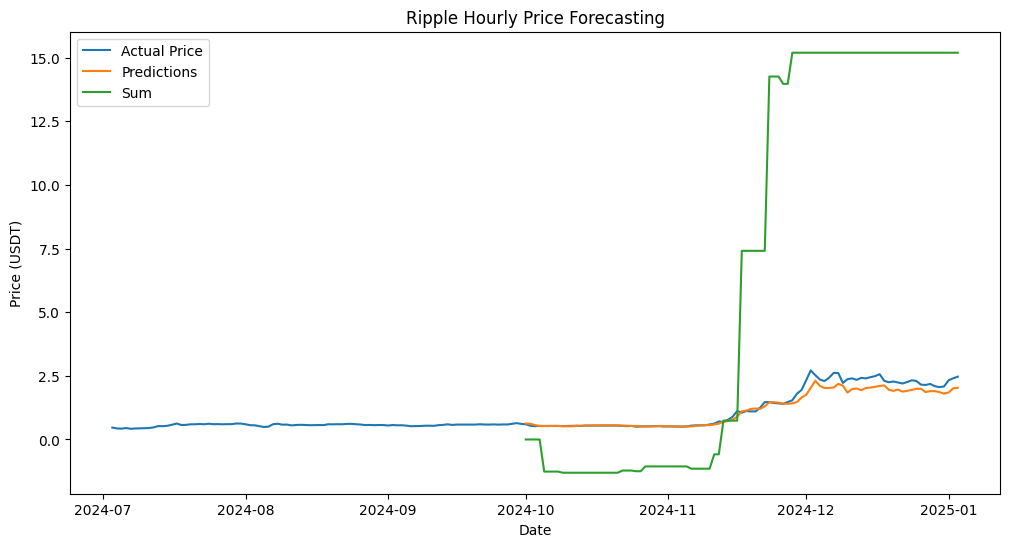

In [31]:
import matplotlib.pyplot as plt
import numpy as np
timeseries = df.index
print(pastData.shape, timeseries.shape,  sum_by_epoch)
# Plot result

plt.figure(figsize=(12, 6))
plt.plot(timeseries, pastData, label='Actual Price')
plt.plot(timeseries[seq_len:], predictions[:], label='Predictions')
plt.plot(timeseries[seq_len:], np.array(sum_by_epoch).reshape(-1, 1), label='Sum')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()